In [1]:
import numpy as np
from scipy.cluster import vq
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
parent = os.path.dirname(os.path.abspath(''))

# Initial Position

In [55]:
data_path = 'AssistiveTrainable_2_dropout=0.05,input_shape=(100, 27),lr=0.005,model=lstm,num_layer=2,num_samplers=16,rdropout=0_2020-05-25_21-25-1544jzulyy'
data_path0 = os.path.join(parent,'logs','ray','discrete','lstm3',data_path,'training_data_0.npz')
data_path1 = os.path.join(parent,'logs','ray','discrete','lstm3',data_path,'training_data_1.npz')

In [56]:
obs0,target0 = np.load(data_path0).values()
obs1,target1 = np.load(data_path1).values()
obs = np.concatenate((obs0,obs1))
target = np.concatenate((target0,target1))

In [50]:
stats_path = os.path.join(parent,'data','twin','stats.npz')
stats_o,stats_t = np.load(stats_path).values()
mean_t,sd_t = stats_t

In [57]:
target = target*sd_t+mean_t

In [35]:
torso_pos = [-0.35, -0.3, 0.48549999]

In [97]:
centroid,label = vq.kmeans2(target[:,0,:],2)
if centroid[0][1] > centroid[1][1]:
    temp = centroid[0]
    centroid[0] = centroid[1]
    centroid[1] = temp
    idx0 = np.where(label == 1)[0]
    idx1 = np.where(label == 0)[0]
else:
    idx0 = np.where(label == 0)[0]
    idx1 = np.where(label == 1)[0]
print(centroid[0])
print(centroid[1])    

target_0 = target[idx0]
target_1 = target[idx1]
target_dist_0 = norm(target_0-centroid[0],axis=1)
target_dist_1 = norm(target_1-centroid[1],axis=1)
print("distance between centroids: ",norm(centroid[0]-centroid[1]))
print("cluster 0 size: ", len(idx0))
print("cluster 1 size: ", len(idx1))

[-0.32251337 -0.19862314  0.7411707 ]
[-0.28163195  0.06412622  0.81448786]
distance between centroids:  0.2758331382486991
cluster 0 size:  511
cluster 1 size:  513


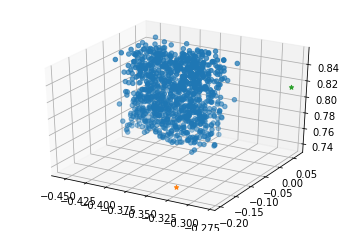

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*(obs[:,0,:3]+torso_pos)),color='tab:blue')
coll0 = ax.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:orange')
coll1 = ax.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:green')

In [100]:
dist = np.linalg.norm(obs[:,0,:3]-target[:,0,:],axis=1)
dist0 = dist[idx0]
dist1 = dist[idx1]

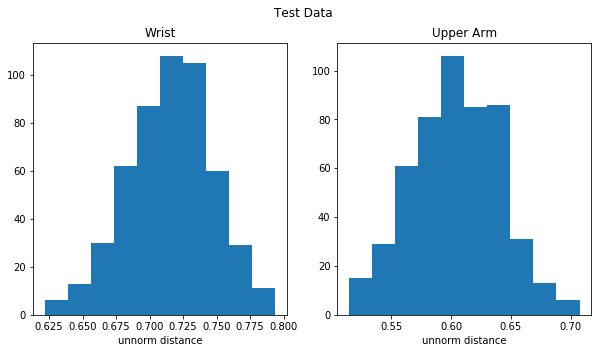

In [102]:
fig,axs = plt.subplots(1,2,figsize=(10,5))

axs[0].hist(dist0.flatten())
axs[0].set_title("Wrist")
axs[0].set_xlabel("unnorm distance")

axs[1].hist(dist1.flatten())
axs[1].set_title("Upper Arm")
axs[1].set_xlabel("unnorm distance")

plt.suptitle("Test Data")

# fig.colorbar(im0,ax=ax[0])
# fig.colorbar(im1,ax=ax[1])

plt.show()

# Validation Density

In [68]:
data = [None,None,None]
tags = ['regression -> classification','regression || classification','original']

loads = []
for i in range(1,41):
    loads.append(np.load(f'{parent}/test/combine_target_results_{1000+i}.npz').values())
data[0] = zip(*loads)
data[0] = [np.concatenate(feature) for feature in data[0]]
data[0] = dict(zip(['target','pred_target','label','pred_label'],data[0]))
del loads

In [69]:
loads = []
for i in range(1,41):
    loads.append(np.load(f'{parent}/test/combine1_target_results_{1000+i}.npz').values())
data[1] = zip(*loads)
data[1] = [np.concatenate(feature) for feature in data[1]]
data[1] = dict(zip(['target','pred_target','label','pred_label'],data[1]))
del loads

In [82]:
loads = []
for i in range(1,41):
    loads.append(list(np.load(f'{parent}/test/dagger2_target_results_{1000+i}.npz').values())
                + list(np.load(f'{parent}/test/binary_target_results_{1000+i}.npz').values()))
data[2] = zip(*loads)
data[2] = [np.concatenate(feature) for feature in data[2]]
data[2] = dict(zip(['pred_target','target','pred_label','label'],data[2]))
data[2]['target'] = np.repeat(data[2]['target'][:,np.newaxis,:],100,axis=1)
data[2]['pred_target'] = data[2]['pred_target'][:,:100,:]
data[2]['pred_label'] = data[2]['pred_label'][:,:100]
data[2]['pred_label'] = 1 - data[2]['pred_label'].round()
del loads

In [83]:
for dataset in data:
    print(*[f"{key}: {value.shape}" for key,value in dataset.items()])

target: (1000, 100, 3) pred_target: (1000, 100, 3) label: (1000,) pred_label: (1000, 100)
target: (1000, 100, 3) pred_target: (1000, 100, 3) label: (1000,) pred_label: (1000, 100)
pred_target: (1000, 100, 3) target: (1000, 100, 3) pred_label: (1000, 100) label: (1000,)


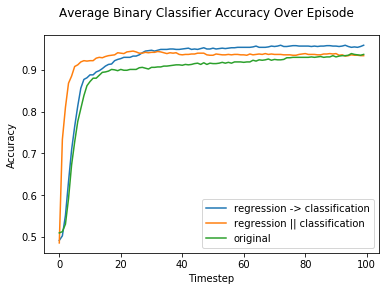

In [84]:
accuracies = [np.mean(dataset['pred_label'].T == dataset['label'],axis=1) for dataset in data]

for accuracy,tag in zip(accuracies,tags):
    plt.plot(range(100),accuracy,label=tag)
plt.suptitle("Average Binary Classifier Accuracy Over Episode")
plt.ylabel("Accuracy")
plt.xlabel("Timestep")
plt.legend()

del accuracy

In [105]:
centroids,idxs = [None,None,None],[None,None,None]
for i,dataset in enumerate(data):
    centroid,label = vq.kmeans2(np.mean(dataset['target'],axis=1),2)
    if centroid[0][1] > centroid[1][1]:
        temp = centroid[0]
        centroid[0] = centroid[1]
        centroid[1] = temp
        idx = np.where(label == 1)[0],np.where(label == 0)[0]
    else:
        idx = np.where(label == 0)[0],np.where(label == 1)[0]
    dataset['seperated targets'] = dataset['target'][idx[0]],dataset['target'][idx[1]]
    print(centroid[0],centroid[1])
    print("distance between centroids: ",norm(centroid[0]-centroid[1]))
    print("cluster 0 size: ", len(idx[0]))
    print("cluster 1 size: ", len(idx[1]))
    centroids[i],idxs[i] = centroid,idx

[-0.29725881 -0.21010944  0.7331274 ] [-0.25966193  0.07330555  0.79280844]
distance between centroids:  0.292060625783839
cluster 0 size:  491
cluster 1 size:  509
[-0.29732506 -0.20907723  0.73215022] [-0.26092539  0.06757265  0.79256822]
distance between centroids:  0.285500308429288
cluster 0 size:  491
cluster 1 size:  509
[-0.32462279 -0.19766311  0.7445247 ] [-0.28285185  0.06445287  0.8166211 ]
distance between centroids:  0.27504088733928644
cluster 0 size:  509
cluster 1 size:  491


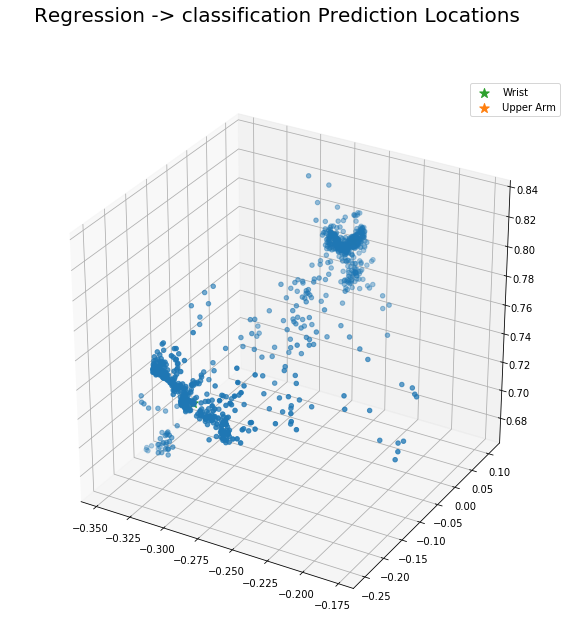

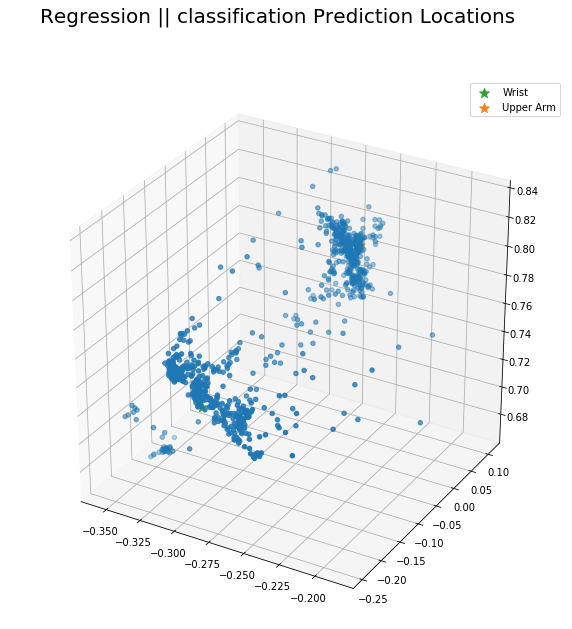

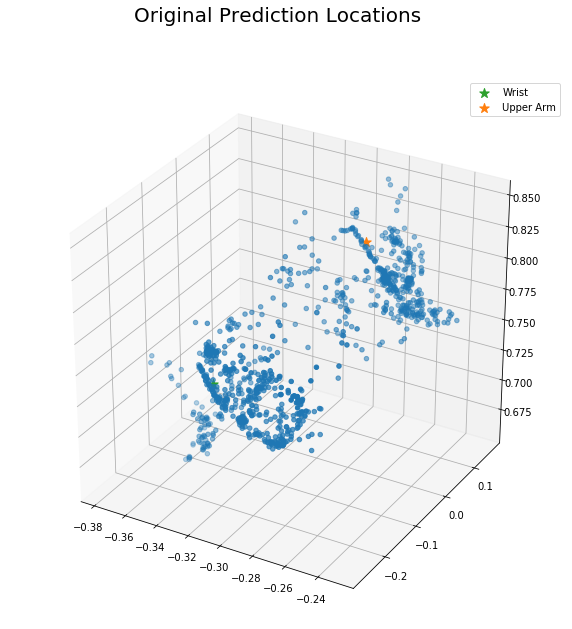

In [106]:
for dataset,centroid,tag in zip(data,centroids,tags):
    fig = plt.figure(figsize=(10,10))
    ax0 = fig.add_subplot(111, projection='3d')
    ax0.scatter(*zip(*dataset['pred_target'][:,-1,:]),color='tab:blue')
    ax0.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:green',s=100,label="Wrist")
    ax0.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:orange',s=100,label="Upper Arm")
    plt.suptitle(f"{tag.capitalize()} Prediction Locations",fontsize=20)
    plt.legend()
del fig,ax0

In [125]:
distances = [norm(dataset['pred_target']-dataset['target'],axis=2) for dataset in data]
sd = np.std(distances[2])

avg_centroid_dists = [np.mean(norm(data[0]['seperated targets'][i]-centroids[0][i],axis=2)) for i in range(2)]
avg_centroid_dists = [dist/sd for dist in avg_centroid_dists]

distances = [dist/sd for dist in distances]
distances = [(dist[idx0],dist[idx1]) for dist,(idx0,idx1) in zip(distances,idxs)]
del sd

In [126]:
for dist in distances:
    print(dist[0].shape,dist[1].shape)

(491, 100) (509, 100)
(491, 100) (509, 100)
(509, 100) (491, 100)


In [127]:
print(avg_centroid_dists)

[0.3914384797886071, 0.3558060982893307]


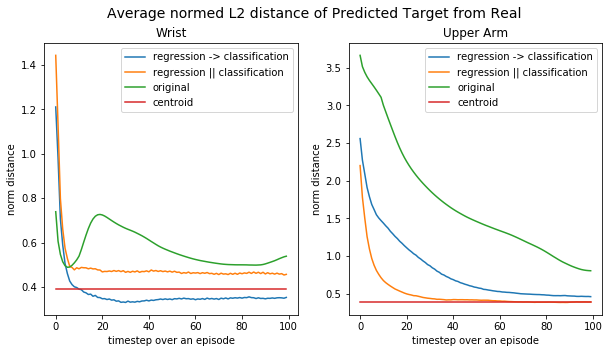

In [133]:
fig,axs = plt.subplots(1,2,figsize=(10,5))

for dist,tag in zip(distances,tags):
    axs[0].plot(range(100),np.mean(dist[0],axis=0),label=tag)
axs[0].plot(range(100),[avg_centroid_dists[0]]*100,label="centroid")
axs[0].set_title("Wrist")
axs[0].set_ylabel("norm distance")
axs[0].set_xlabel("timestep over an episode")
axs[0].legend()

for dist,tag in zip(distances,tags):
    axs[1].plot(range(100),np.mean(dist[1],axis=0),label=tag)
axs[1].plot(range(100),[avg_centroid_dists[0]]*100,label="centroid")
axs[1].set_title("Upper Arm")
axs[1].set_ylabel("norm distance")
axs[1].set_xlabel("timestep over an episode")
axs[1].legend()

plt.suptitle("Average normed L2 distance of Predicted Target from Real", fontsize=14)

plt.show()

# Training Density

In [36]:
import os
parent = os.path.dirname(os.path.abspath(''))
obs,targets = np.load(os.path.join(parent,"samples","trajectory.processed","t.noised_trajectory.npz")).values()
# del obs

In [23]:
prediction = np.load(os.path.join(parent,"data","twin","prediction.npy"))

In [37]:
centroid,label = vq.kmeans2(targets,2,minit='++')
if centroid[0][1] > centroid[1][1]:
    temp = centroid[0]
    centroid[0] = centroid[1]
    centroid[1] = temp
    idx0 = np.where(label == 0)[0]
    idx1 = np.where(label == 1)[0]
    label[idx1] = 0
    label[idx0] = 1
idx0 = np.where(label == 0)[0]
idx1 = np.where(label == 1)[0]
print(centroid)
print("distance between centroids: ",norm(centroid[0]-centroid[1]))
print("cluster 0 size: ", len(np.where(label==0)[0]))
print("cluster 1 size: ", len(np.where(label==1)[0]))

[[-0.32119506 -0.19763412  0.74035324]
 [-0.27993492  0.06497009  0.81027984]]
distance between centroids:  0.27486924609941127
cluster 0 size:  24675
cluster 1 size:  25325


In [38]:
np.savez_compressed(os.path.join(parent,"samples","trajectory.processed","t.noised_trajectory.npz"),obs=obs,targets=targets,classes=label)

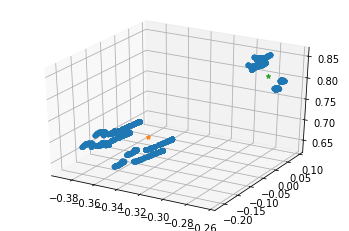

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*targets),color='tab:blue')
coll0 = ax.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:orange')
coll1 = ax.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:green')

In [28]:
print(std)

0.131709247085929


In [26]:
distances = norm(prediction-targets[:,np.newaxis,:],axis=2)
distances /= std
dist0 = distances[idx0]
dist1 = distances[idx1]

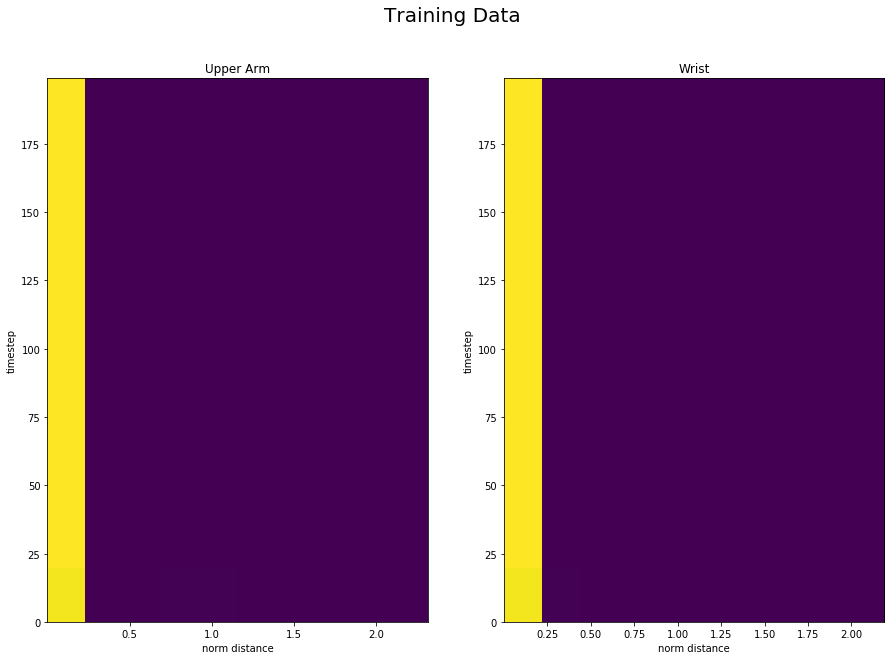

In [27]:
fig,axs = plt.subplots(1,2,figsize=(15,10))

hist0,xedges0,yedges0 = np.histogram2d(dist0.flatten(),list(range(200))*len(dist0))
extent0 = [xedges0[0], xedges0[-1], yedges0[0], yedges0[-1]]
im0 = axs[0].imshow(hist0.T, extent=extent0, origin='lower',aspect='auto')
axs[0].set_title("Upper Arm")
axs[0].set_xlabel("norm distance")
axs[0].set_ylabel("timestep")

hist1,xedges1,yedges1 = np.histogram2d(dist1.flatten(),list(range(200))*len(dist1))
extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]
im1 = axs[1].imshow(hist1.T, extent=extent1, origin='lower',aspect='auto')
axs[1].set_title("Wrist")
axs[1].set_xlabel("norm distance")
axs[1].set_ylabel("timestep")

plt.suptitle("Training Data",fontsize=20)
# fig.colorbar(im0,ax=ax[0])
# fig.colorbar(im1,ax=ax[1])

plt.show()

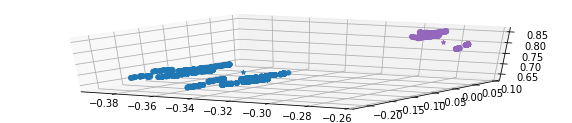

In [15]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*prediction[idx0,-1,:]),color='tab:blue')
ax.scatter(*zip(*prediction[idx1,-1,:]),color='tab:purple')
coll0 = ax.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:blue')
coll1 = ax.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:purple')

[186.67411858  30.62776683   3.20690853]
[-0.15775127 -0.12599338 -0.09423549 -0.0624776  -0.03071971  0.00103817
  0.03279606  0.06455395  0.09631184  0.12806973  0.15982762]


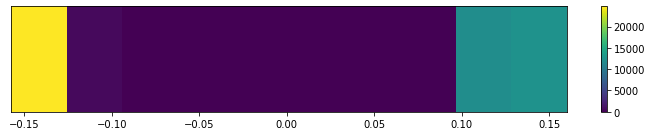

In [18]:
s,d,vt = np.linalg.svd(prediction[:,100,:],full_matrices=False)
print(d)

# plt.scatter(s.T[1]*d[1],s.T[0]*d[0])

heat,edges = np.histogram(s.T[1]*d[1])
print(edges)
extent = [edges[0],edges[-1],0,1]
plt.rcParams["figure.figsize"] = 10,2
plt.imshow(heat[np.newaxis,:],extent=extent,aspect='auto')
plt.yticks([])
# plt.tight_layout()
plt.colorbar()